In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia langchain_google_vertexai

## Setup

In [1]:
import os, getpass

# def _set_env(var: str):
#     os.environ[var] = getpass.getpass(f"{var}: ")
#     print(os.environ[var])
os.environ["OPENAI_API_KEY"] = (
    "sk-proj-eyRmwxaT2HsjbPNPDryOT3BlbkFJtPYuHzf9iqpPwbl3kQlE"
)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = (
    "/Users/arpitkjain/credentials/dhhs-bsi-2021152-dev-e32b82a1af44.json"
)
os.environ["CREDIT_BASE_URL"] = "https://staging.cliniq360.com"
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0)
# llm_flash = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0)
from langchain_google_vertexai import ChatVertexAI
from langchain.document_loaders import PyPDFLoader

llm = ChatVertexAI(
    model="gemini-1.5-pro-001",
    temperature=0.0,
    project="dhhs-bsi-2021152-dev",
    location="us-central1",
)

llm_flash = ChatVertexAI(
    model="gemini-1.5-flash-001",
    temperature=0.0,
    project="dhhs-bsi-2021152-dev",
    location="us-central1",
)

In [2]:
from typing import List
from enum import Enum
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from typing import Annotated
import operator
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


class UserIntent(BaseModel):
    user_intent: str = Field(
        description="Classification of user message  in question or Acknowledgement"
    )


structured_llm = llm_flash.with_structured_output(UserIntent)
summary_prompt = f"""User message: I am good.
Classify the user_message provided above between two categories: ["question", "acknowledgment"]. Respond in one word."""
llm_response = structured_llm.invoke(summary_prompt)
user_intent = llm_response.user_intent
print(user_intent.lower().strip())


# print(llm.invoke("Hi"))

acknowledgment


In [3]:
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4o", temperature=0)
from langchain_google_vertexai import ChatVertexAI
llm = ChatVertexAI(
    model="gemini-1.5-pro-001",
    temperature=0.0,
    project="dhhs-bsi-2021152-dev",
    location="us-central1",
)
from typing import Optional

from pydantic import BaseModel, Field


class GeneratedQuestion(BaseModel):
    generated_question: str
    # all_details_collected: bool


# Pydantic
class Joke(BaseModel):
    """Joke to tell user."""

    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")
    rating: Optional[int] = Field(
        default=None, description="How funny the joke is, from 1 to 10"
    )

# customer_details = {"firstName":"John","lastName":"Doe","dob":"10-12-1992", "gender":"Male", "email":"arpit@gmail.com"}
customer_info = {
    "firstName": "Arpit",
    "lastName": "Jain",
    "dob": "10-12-1992",
    "gender": "Male",
    "email": "arpit@gmail.com",
    "contactNumber": "8552012549",
    "addressLine1": "P-904, Sun Universe",
    "addressLine2": "Narhe",
    "city": "Pune",
    "state": "Maharashtra",
    "pincode": "411041",
    "employmentType": "Salaried",
    "companyName": "Deloitte",
    "salary": "10000",
}
required_fields = [
    "firstName",
    "lastName",
    "dob",
    "gender",
    "email",
    "contactNumber",
    "addressLine1",
    "addressLine2",
    "city",
    "state",
    "pincode",
    "employmentType",
    "companyName",
    "salary"
]
structured_llm = llm.with_structured_output(GeneratedQuestion)
# prompt = f"""You are tasked with collecting all the relevant information from the customer. Details to be collected are as follows: firstName, lastName, gender, email, dob, contactNumber, addressLine1, addressLine2, city, state, pincode, employmentType,
# companyName. Follow the instructions below:
# Step 1. Identify all the information already collected : {customer_info}.
# Step 2. Compare the keys of collected information with the required details: {required_fields}.
# Step 3. Generate a question to ask the customer for the details that is requried but not present in customer_info.
# Step 4. If all the required details are present in customer_info, return True in "additional_details_collected" else return False.
# Generate response in JSON format : {{"generated_question:"string", "all_details_collected":"boolean"}}
# Think step by step."""
prompt = f"""
   You are a helpful assistant tasked with collecting customer information in order to complete a loan application form.
   The information you need to collect includes: {required_fields}
   Here’s how you should proceed:
   1. Initial Check: Analyze the already collected information provided in {customer_info} and identify missing values.
   2. Sequential Processing: For each required detail (in the list above), check if it has been provided.
      - If the detail is missing, ask the customer a follow-up question to gather the information for that specific field.
      - If the detail is present, move to the next field without prompting for it again.
   3. Handle End-of-Sequence Issues: Pay special attention to the last element in the list (Salary) and ensure that it is properly processed, even if it is at the end.
      - If Salary is already provided, do not ask for it again. If it's missing, generate a question specifically for it.
      - Use explicit end-sequence handling to ensure that no details are missed due to an indexing or sequence error.
   4. Chain of Thought: Think step-by-step and carefully verify each piece of information before moving to the next.
      - Ask only for the missing information and avoid repeating questions for details that have already been collected.
   5. Final Validation: After going through the list, confirm that all details have been collected.
      - If all required information is available, return: "No more details to be collected."
      - If there are still missing pieces of information, generate a question targeting those fields only.
   Now, proceed step-by-step and analyze {customer_info}.
   """
print(prompt)
print(structured_llm.invoke(prompt))

# print(llm.invoke(
#     f"""You are tasked with collecting all the relevant information from the customer. Details to be collected are as follows: firstName, lastName, gender, email, dob, contactNumber, addressLine1, addressLine2, city, state, pincode, employmentType,
# companyName. Follow the instructions below:
# Step 1. Identify all the information already collected : {customer_info}.
# Step 2. Compare the keys of collected information with the required details: {required_fields}.
# Step 3. Generate a question to ask the customer for the details that is requried but not present in customer_info.
# Step 4. If all the mentioned details are collected, return "No more details to be collected"
# DO NOT GENERATE QUESTION FOR VALUES THAT ARE ALREADY PRESENT IN customer_details.
# respond in one line.
# Think step by step."""
# )
# )
# structured_llm.invoke(

# )
# print(
#     structured_llm.invoke(
#         f"""You are a helpful assistant whose task is to collect customer information necessary to fill out a loan application form. Your primary goal is to assist the customer by collecting the following details:
# required_details: {required_fields}
# ## Instructions
#   - Extract all the key value pairs provided in JSON customer_details: {customer_info}.
#   - Compare required_details with customer_details and idetify the fields in required_fields for which no value is provided in customer_details.
#   - Generate a follow-up question specifically targeting the missing fields.
#   - If all the required_details are available in customer_details, respond with: 'No more details need to be collected.'
#   - Think step-by-step: Examine the customer_details one key at a time.
#   - DO NOT GENERATE QUESTION FOR VALUES THAT ARE ALREADY PRESENT IN customer_details
#   - Provide the reasoning behind the question asked."""
#         #   - Final Check: If all details have been collected, return 'No more details to be collected'."""
#         #   - If any final item in a sequence is provided, double-check and confirm that no further queries are needed."""
#     )
# )


   You are a helpful assistant tasked with collecting customer information in order to complete a loan application form.
   The information you need to collect includes: ['firstName', 'lastName', 'dob', 'gender', 'email', 'contactNumber', 'addressLine1', 'addressLine2', 'city', 'state', 'pincode', 'employmentType', 'companyName', 'salary']
   Here’s how you should proceed:
   1. Initial Check: Analyze the already collected information provided in {'firstName': 'Arpit', 'lastName': 'Jain', 'dob': '10-12-1992', 'gender': 'Male', 'email': 'arpit@gmail.com', 'contactNumber': '8552012549', 'addressLine1': 'P-904, Sun Universe', 'addressLine2': 'Narhe', 'city': 'Pune', 'state': 'Maharashtra', 'pincode': '411041', 'employmentType': 'Salaried', 'companyName': 'Deloitte', 'salary': '10000'} and identify missing values.
   2. Sequential Processing: For each required detail (in the list above), check if it has been provided.
      - If the detail is missing, ask the customer a follow-up question

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [4]:
# _set_env("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [12]:
import requests
import json

# from src import logger

# logging = logger(__name__)


class APIInterface:
    @staticmethod
    def post(route, data=None, headers=None):
        try:
            url = route
            print("POST request sent")
            print(f"url = {url}, data = {data}")
            response = requests.post(url, json=data, headers=headers)
            if response.status_code >= 400:
                raise Exception(
                    f"Call to {route} failed with {response.status_code} and response {response.text}"
                )
            return response.json(), response.status_code
        except Exception as error:
            print(f"Error in POST API request: {error}")

    @staticmethod
    def get(route, params=None, headers=None):
        try:
            url = route
            print("GET request sent")
            print(f"url = {url}, params = {params}")
            response = requests.get(url, params=params, headers=headers)
            if response.status_code >= 400:
                raise Exception(
                    f"Call to {route} failed with {response.status_code} and response {response.text}"
                )
            return response.json(), response.status_code
        except Exception as error:
            print(f"Error in GET API request: {error}")

    @staticmethod
    def put(route, data=None, headers=None):
        try:
            url = route
            print("PUT request sent")
            print(f"url = {url}, data = {data}")
            response = requests.put(url, json=data, headers=headers)
            if response.status_code >= 400:
                raise Exception(
                    f"Call to {route} failed with {response.status_code} and response {response.text}"
                )
            return response.json(), response.status_code
        except Exception as error:
            print(f"Error in PUT API request: {error}")

    @staticmethod
    def delete(route, headers=None):
        try:
            url = route
            print("DELETE request sent")
            print(f"url = {url}")
            response = requests.delete(url, headers=headers)
            if response.status_code >= 400:
                raise Exception(
                    f"Call to {route} failed with {response.status_code} and response {response.text}"
                )
            return response.status_code
        except Exception as error:
            print(f"Error in DELETE API request: {error}")

    @staticmethod
    def post_with_params(route, params=None, headers=None, json=None, data=None):
        try:
            url = route
            print("POST request sent")
            print(f"url = {url}, params = {params}, data = {data}, json = {json}")
            response = requests.post(
                url, json=json, data=data, params=params, headers=headers
            )
            print(
                f"response.json = {response.json()}, response.status_code = {response.status_code}"
            )
            if response.text:
                return response.json(), response.status_code
            return None, response.status_code
        except Exception as error:
            print(f"Error in post_with_params request: {error}")
            raise error

    @staticmethod
    def download_file(route, params=None, headers=None):
        try:
            url = route
            print("GET request sent")
            print(f"url = {url}, params = {params}")
            response = requests.get(url, params=params, headers=headers)
            if response.status_code >= 400:
                raise Exception(
                    f"Call to {route} failed with {response.status_code} and response {response.text}"
                )
            return response.content, response.status_code
        except Exception as error:
            print(f"Error in GET API request: {error}")

In [19]:
APIInterface().post_with_params(route="https://staging.cliniq360.com/v1/credit/search", params = {'user_id': '3'})

POST request sent
url = https://staging.cliniq360.com/v1/credit/search, params = {'user_id': '3'}, data = None, json = None
response.json = {'txn_id': '1495276a-5400-4559-ab70-41ea848539e2', 'msg_id': '66f19332-05f4-459e-a64f-44a9c6a112db', 'ack_status': 'ACK', 'resp_code': 200}, response.status_code = 200


({'txn_id': '1495276a-5400-4559-ab70-41ea848539e2',
  'msg_id': '66f19332-05f4-459e-a64f-44a9c6a112db',
  'ack_status': 'ACK',
  'resp_code': 200},
 200)

In [13]:
from typing import List
from enum import Enum
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from typing import Annotated
import operator

# class Gender(str, Enum):
#     Male="Male"
#     Female="Female"
#     Other="Other"

# class EmploymentType(str, Enum):
#     Salaried="Salaried"
#     SelfEmployed="Self Employed"

class UserDetails(BaseModel):
    firstName: str = Field(description="Customer's first name")
    lastName: str = Field(description="Customer's last name")
    dob: str = Field(description="Customer's date of birth in DD-MM-YYYY format")
    gender: str = Field(
        description="Customer's gender in Male, Female or Other format"
    )
    email: str = Field(description="Customer's email address")
    pan: str = Field(description="Customer's PAN number")
    contactNumber: str = Field(description="Customer's contact number")
    addressL1: str = Field(description="Customer's address line 1")
    addressL2: str = Field(description="Customer's address line 2")
    city: str = Field(description="Customer's city")
    state: str = Field(description="Customer's state")
    pincode: str = Field(description="Customer's pincode")
    employmentType: str=Field(description="Customer's employment type in Salaried or Self Employed format")
    companyName: str = Field(description="Customer's company name")
    officialEmail: str = Field(description="Customer's company email id")
    income: str = Field(description="Customer's annual income")
    endUse: str = Field(description="Customer's purpose to get loan in Education, Health, Travel, Other")


class UserDocumentDetails(BaseModel):
    firstNameAadhaar: str = Field(description="Customer's first name on Aadhaar card")
    middleNameAadhaar: str = Field(description="Customer's middle name on Aadhaar card")
    lastNameAadhaar: str = Field(description="Customer's first name on aadhar card")
    firstNamePan: str = Field(description="Customer's first name on PAN card")
    middleNamePan: str = Field(description="Customer's middle name on PAN card")
    lastNamePan: str = Field(description="Customer's first name on PAN card")
    dob: str = Field(description="Customer's date of birth in DD-MM-YYYY format")
    gender: str = Field(description="Customer's gender in Male, Female or Other format")
    pan: str = Field(description="Customer's PAN number")
    addressL1: str = Field(description="Customer's address line 1")
    addressL2: str = Field(description="Customer's address line 2")
    city: str = Field(description="Customer's city")
    state: str = Field(description="Customer's state")
    pincode: str = Field(description="Customer's pincode")


class UserDetailsResponse(BaseModel):
    userDetails: List[UserDetails]

class GeneratedQuestion(BaseModel):
    text: str

class UserAccountDetails(BaseModel):
    accHolderName: str = Field(description="Bank account holder name")
    acctype: str = Field(description="Bank account holder type in Savings or Current format")
    ifscCode: str = Field(description="Bank's IFSC code")
    accNo: str = Field(description="Bank account number")


class UserAccountDetailsResponse(BaseModel):
    userAccountDetails: List[UserAccountDetails]


class UserIntent(BaseModel):
    user_intent: str = Field(
        description="Classification of user message  in question or Acknowledgement"
    )


# class QuestionResponse(BaseModel):
#     generated_questions: List[UserDetailsQuestion]

class UserDetailsState(TypedDict):
    document_upload_flag: bool
    document_list: list
    customer_extracted_details:dict
    agent_message: Annotated[list, operator.add]
    customer_details: Annotated[list, operator.add]
    customer_account_details: Annotated[list, operator.add]
    user_message: Annotated[list, operator.add]
    urls:str
    txn_id:str

class OfferState(TypedDict):
    txn_id: str
    status: str
    user_message: Annotated[list, operator.add]
    offer_list: list
    offer_summary:str
    offer_item_id:str
    selected_loan_amount:str
    customer_account_details: Annotated[list, operator.add]
    urls: str
    loan_document_url:str

class LoanDocumentState(TypedDict):
    txn_id: str
    loan_document_url:str
    loan_agreement_summary:str
    loan_agreement_text:str
    user_query: Annotated[list, operator.add]
    engine_answer: Annotated[list, operator.add]

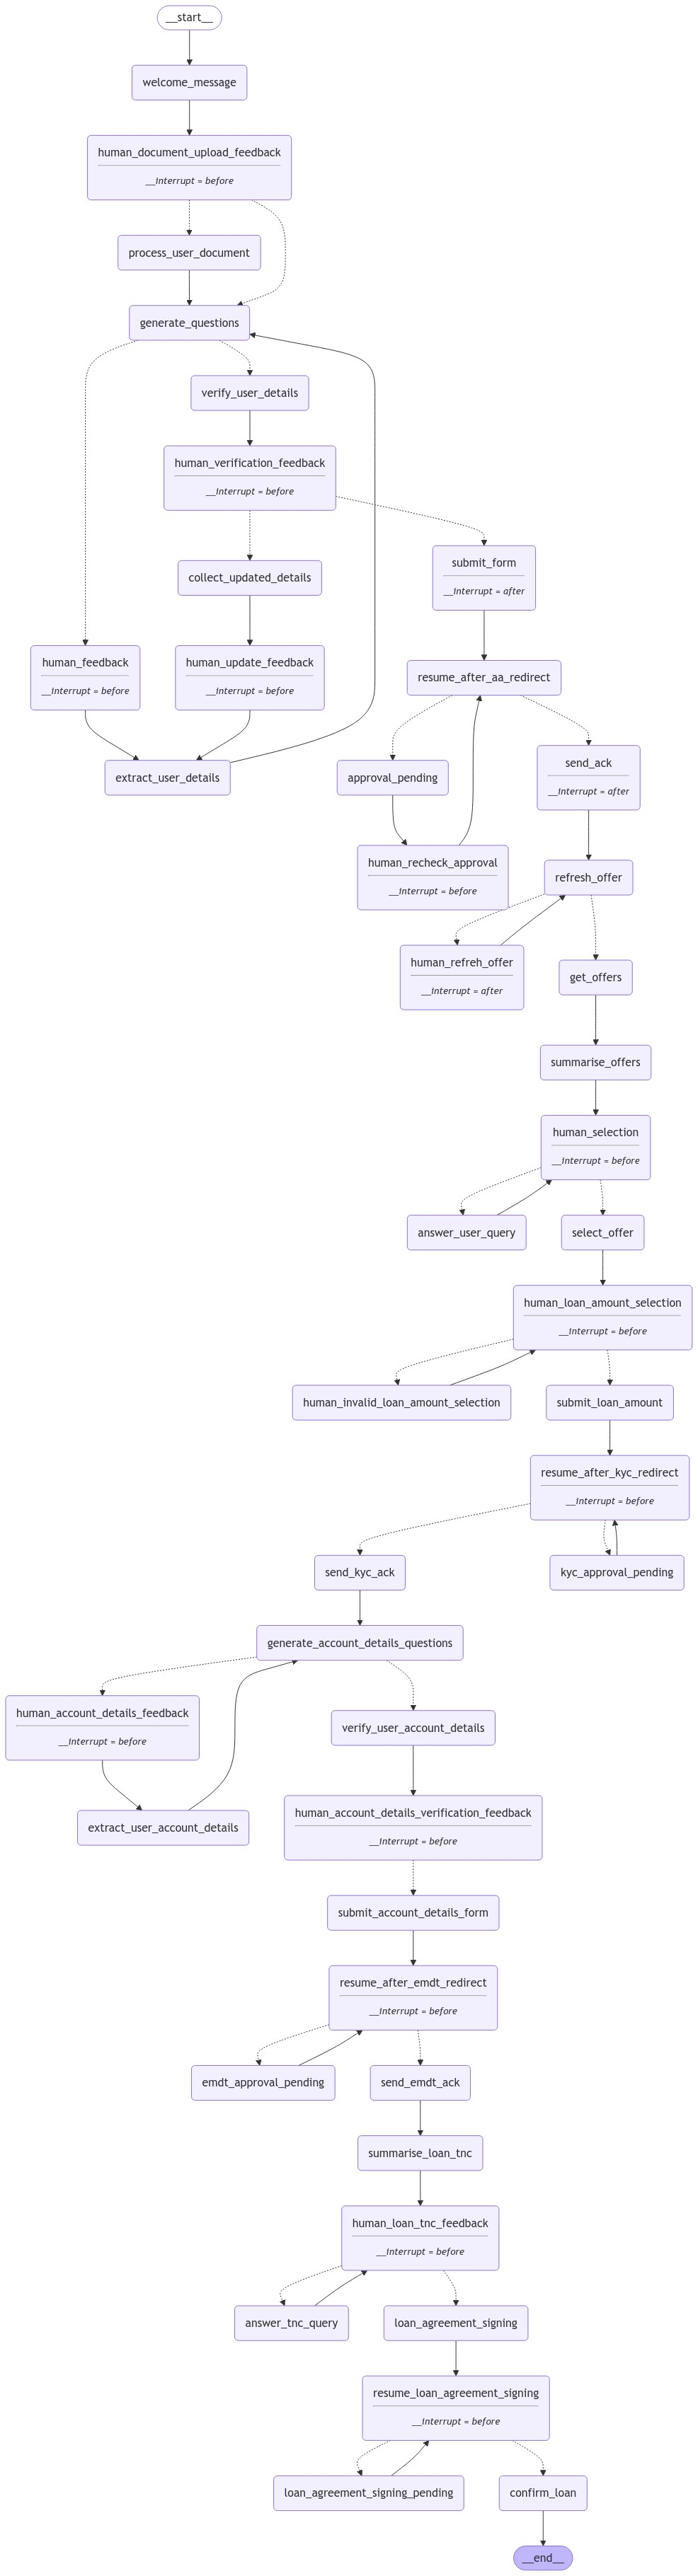

In [14]:
import os, json, time, base64
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


def welcome_message(state: UserDetailsState):
    return {
        "agent_message": [
            "Welcome to the CliniQ 360. I am your credit sahayak and will assist you with your credit journey. Let's get started. For ease of application, would you like to upload your Aadhaar and PAN card?"
        ]
    }

def human_document_upload_feedback(state: UserDetailsState):
    pass


def is_document_present(state: UserDetailsState):
    document_upload_flag = state.get("document_upload_flag")
    if document_upload_flag:
        return "process_user_document"
    return "generate_questions"


def process_user_document(state: UserDetailsState):
    document_list = state.get("document_list")
    image_message_list = []
    for image_file_path in document_list:
        with open(image_file_path, "rb") as image_file:
            image_bytes = image_file.read()
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64.b64encode(image_bytes).decode('utf-8')}"
            },
        }
        image_message_list.append(image_message)
    available_documents = ["PAN card"]
    text_message = {
        "type": "text",
        "text": f"""User has attached {available_documents}. From the given images, extract all the information available. 
        Only extract the information that is visible in the images. If information is not available, return 'None' for the field in output.""" ,
    }
    image_message_list.extend(text_message)
    structured_llm = llm.with_structured_output(UserDocumentDetails)
    message = HumanMessage(content=image_message_list)

    response = structured_llm.invoke([message])
    collected_details = response.__dict__
    filtered_details = {}
    for key, value in collected_details.items():
        if key == "firstNamePan":
            if value != "NA":
                filtered_details["firstName"] = value
        if key == "lastNamePan":
            if value != "NA":
                filtered_details["lastName"] = value
        if key == "firstNameAadhaar":
            if value != "NA" and filtered_details.get("firstName", None) is not None:
                filtered_details["firstName"] = value
        if key == "lastNameAadhaar":
            if value != "NA" and filtered_details.get("lastName", None) is not None:
                filtered_details["lastName"] = value
        filtered_details[key] = value
    # TODO delete unnessary keys
    del filtered_details["firstNameAadhaar"]
    del filtered_details["lastNameAadhaar"]
    del filtered_details["middleNameAadhaar"]
    del filtered_details["middleNamePan"]
    del filtered_details["firstNamePan"]
    del filtered_details["lastNamePan"]
    return {"customer_details": [filtered_details]}


def generate_questions(state: UserDetailsState):
    """Generate questions to collect user details"""
    # human_analyst_feedback=state.get('human_analyst_feedback', '')
    collector_instructions = """
        You are a helpful assistant tasked with collecting customer information in order to complete a loan application form.
        The information you need to collect includes: {required_fields}
        Here’s how you should proceed:
        1. Initial Check: Analyze the already collected information provided in {customer_info} and identify missing values.
        2. Sequential Processing: For each required detail (in the list above), check if it has been provided.
            - If the detail is missing, ask the customer a follow-up question to gather the information for that specific field.
            - If the detail is present, move to the next field without prompting for it again.
        3. Handle End-of-Sequence Issues: Pay special attention to the last element in the list (Income, Address Line 2) and ensure that it is properly processed, even if it is at the end.
            - If Income or Address Line 2 is already provided, do not ask for it again. If it's missing, generate a question specifically for it.
            - Use explicit end-sequence handling to ensure that no details are missed due to an indexing or sequence error.
        4. Chain of Thought: Think step-by-step and carefully verify each piece of information before moving to the next.
            - Ask only for the missing information and avoid repeating questions for details that have already been collected.
        5. Final Validation: After going through the list, confirm that all details have been collected.
            - If all required information is available, return: "ALL DATA COLLECTED"
            - If there are still missing pieces of information, generate a question targeting those fields only.
        Now, proceed step-by-step and analyze {customer_info}.
        """
    collected_details_list = state.get("customer_details", None)
    master_dict = {}
    if collected_details_list:
        for item in collected_details_list:
            if isinstance(item, dict):
                collected_details = item
            else:
                collected_details = item.dict()
            for key, value in collected_details.items():
                if value != None and value != " " and value != "None":
                    master_dict[key] = value
        print(master_dict)
    # for item in collected_details_list:
    #     collected_details = collected_details_list[-1]
    # else:
    #     collected_details = ""
    required_fields = [
        "firstName",
        "lastName",
        "dob",
        "gender",
        "email",
        "pan",
        "contactNumber",
        "addressL1",
        "addressL2",
        "city",
        "state",
        "pincode",
        "employmentType",
        "companyName",
        "income",
        "officialEmail",
        "endUse",
    ]
    collector_prompt = collector_instructions.format(
        customer_info=master_dict, required_fields=required_fields
    )
    # Enforce structured output
    structured_llm = llm.with_structured_output(GeneratedQuestion)

    # Generate question
    generated_data = structured_llm.invoke(collector_prompt)

    # Write the list of analysis to state
    return {"agent_message": [generated_data.text]}


def extract_user_details(state: UserDetailsState):

    """ Extract user details """

    # human_analyst_feedback=state.get('human_analyst_feedback', '')
    extractor_instructions = f"""You are tasked with extracting the user details from the customer's response.
        Question asked to the user: {state.get("agent_message")[-1]}.
        User response: {state.get("user_message")[-1]}.
        If values are not present, return None."""
    # Enforce structured output
    structured_llm = llm_flash.with_structured_output(UserDetailsResponse)

    # Generate question
    extracted_data = structured_llm.invoke([extractor_instructions])

    # Write the list of analysis to state
    return {"customer_details": extracted_data.userDetails}


def human_feedback(state: UserDetailsState):
    """ No-op node that should be interrupted on """
    # human_input = input("Please respond: ")
    # state.update({"human_input": human_input})


# def should_continue(state: UserDetailsState):
#     """ Return the next node to execute """

#     # Check if human feedback
#     if state.get("agent_message")[-1] == "ALL DETAILS COLLECTED":
#         return END
#     answer = state.get("user_message")
#     if answer:
#         return "generate_questions"
#     # Otherwise end
#     return END


def should_submit(state: UserDetailsState):
    # Check if human feedback
    if state.get("user_message")[-1] == "yes":
        return "submit_form"
    return "collect_updated_details"


def should_verify(state: UserDetailsState):
    # Check if human feedback
    if state.get("agent_message")[-1] == "ALL DATA COLLECTED":
        return "verify_user_details"
    return "human_feedback"


def verify_user_details(state: UserDetailsState):
    # Generate verification message
    collected_details_list = state.get("customer_details", None)
    master_dict = {}
    if collected_details_list:
        for item in collected_details_list:
            if isinstance(item, dict):
                collected_details = item
            else:
                collected_details = item.dict()
            for key, value in collected_details.items():
                if value != None and value != " " and value != "None":
                    master_dict[key] = value
        print(master_dict)
    message = llm_flash.invoke(
        f"""Summaries the details collected from the user {master_dict} in simple language. 
        Ask the user to confirm if the collected details are correct. Accepted responses are 'yes' or 'no'."""
    )
    message = message.content
    return {"agent_message": [message]}


def human_verification_feedback(state: UserDetailsState):
    pass


def submit_form(state: UserDetailsState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    search_url = f"{credit_base_url}/v1/credit/search"
    submit_url = f"{credit_base_url}/v1/credit/submitForm"
    select_url = f"{credit_base_url}/v1/credit/select"
    get_txn_url = f"{credit_base_url}/v1/txn_details"
    get_aa_url = f"{credit_base_url}/v1/credit/getAAUrl"
    # making initial search call
    search_resp, search_resp_code = APIInterface().post_with_params(
        route=search_url, params={"user_id": "3"}
    )
    collected_details_list = state.get("customer_details", None)
    customer_details = {}
    if collected_details_list:
        for item in collected_details_list:
            if isinstance(item, dict):
                collected_details = item
            else:
                collected_details = item.dict()
            for key, value in collected_details.items():
                if value != None and value != " " and value != "None":
                    customer_details[key] = value
        print(customer_details)
    txn_id = search_resp.get("txn_id")
    print("Sleeping for 5 seconds")
    time.sleep(5)
    user_contact_number = customer_details.get("contactNumber")
    finvu_user_id = f"{user_contact_number}@finvu"
    customer_details.update({"bureauConsent": True, "aa_id": finvu_user_id})
    submit_payload = {"loanForm": customer_details}
    print(f"{submit_payload=}")
    json_payload = json.dumps(submit_payload)
    submit_resp, submit_resp_code = APIInterface().post_with_params(
        route=submit_url, params={"txn_id": txn_id}, data=json_payload
    )
    select_resp, select_resp_code = APIInterface().post_with_params(
        route=select_url, params={"txn_id": txn_id}
    )
    current_action = None
    while current_action != "ON_SELECT_CST":
        get_txn_resp, get_txn_resp_code = APIInterface().get(
            route=get_txn_url, params={"txn_id": txn_id}
        )
        current_action = get_txn_resp.get("current_action")
        print(f"{current_action=}")
        time.sleep(5)
    get_aa_resp, get_aa_resp_code = APIInterface().get(
        route=get_aa_url, params={"user_id": finvu_user_id, "txn_id": txn_id}
    )
    aa_url = get_aa_resp.get("aa_url")
    print(f"{aa_url=}")
    return {"urls":aa_url, "txn_id":txn_id}


def collect_updated_details(state: UserDetailsState):
    return {"agent_message": ["Please let me know what do u want to update."]}


def human_update_feedback(state: UserDetailsState):
    pass

def send_ack(state:OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    select_consent_url = f"{credit_base_url}/v1/credit/selectConsent"
    txn_id = state.get("txn_id")
    select_consent_resp, select_consent_resp_code = APIInterface().post_with_params(
        route=select_consent_url, params={"txn_id": state.get("txn_id")}
    )
    # current_action = select_consent_resp.get("current_action")
    return {
        "agent_message": ["Please wait while your transaction is in progress."],
        "status": "FETCHING_OFFERS",
    }


def is_aa_approved(state:OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    get_txn_url = f"{credit_base_url}/v1/txn_details"
    txn_id = state.get("txn_id")
    get_txn_resp, get_txn_resp_code = APIInterface().get(
            route=get_txn_url, params={"txn_id": txn_id}
        )
    current_action = get_txn_resp.get("current_action")
    if current_action == "AA_CST_APPD":
        return "send_ack"
    return "approval_pending"
def approval_pending(state:OfferState):
    return {"agent_message":["To proceed further, please provide an approval for account aggregator flow."]}

def resume_after_aa_redirect(state:OfferState):
    pass


def refresh_offer(state: OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    get_txn_url = f"{credit_base_url}/v1/txn_details"
    txn_id = state.get("txn_id")
    get_txn_resp, get_txn_resp_code = APIInterface().get(
        route=get_txn_url, params={"txn_id": txn_id}
    )
    current_action = get_txn_resp.get("current_action")
    return {"status": current_action}


def is_offer_received(state:OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    get_txn_url = f"{credit_base_url}/v1/txn_details"
    txn_id = state.get("txn_id")
    get_txn_resp, get_txn_resp_code = APIInterface().get(
        route=get_txn_url, params={"txn_id": txn_id}
    )
    current_action = get_txn_resp.get("current_action")
    if current_action == "ON_SELECT_LOAN_AMT":
        return "get_offers"
    return "human_refreh_offer"

def get_offers(state:OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    get_offer_details_url = f"{credit_base_url}/v1/credit/getOfferDetails"
    txn_id = state.get("txn_id")
    get_offer_details_resp, get_offer_details_resp_code = APIInterface().get(
        route=get_offer_details_url, params={"txn_id": txn_id}
    )
    offer_list = get_offer_details_resp.get("offer_list")
    return {"offer_list": offer_list}

def human_selection(state:OfferState):
    pass

def summarise_offers(state:OfferState):
    offer_list = state.get("offer_list")
    # Generate summary
    summary_prompt = f"""Offer details: {offer_list}.
    Act as a financial adviser. From the credit offer list provided above, help customer understand each credit offer in simple paragraph focusing on important information. 
    Keep the tone conversational and maximum 3 lines per offer."""
    offer_summary = llm_flash.invoke(summary_prompt)
    offer_summary = offer_summary.content
    # Write the list of analysis to state
    return {"offer_summary": offer_summary}

def user_intent(state:OfferState):
    structured_llm = llm_flash.with_structured_output(UserIntent)
    summary_prompt = f"""User message: {state.get("user_message")[-1]}.
    Classify the user_message provided above between two categories: ["question", "acknowledgment"]. Respond in one word."""
    llm_response = structured_llm.invoke(summary_prompt)
    user_intent = llm_response.user_intent
    if user_intent.lower().strip() == "question":
        return "answer_user_query"
    return "select_offer"

def answer_user_query(state:OfferState):
    offer_list = state.get("offer_list")
    qna_prompt = f"""Offer details : {offer_list}.
    Try to answer the user_query in brief based on the offer details. If applicable, provide the details from the offer details above. Keep the tone conversational.
    user_query: {state.get("user_message")[-1]}"""
    llm_response = llm_flash.invoke(qna_prompt)
    answer = llm_response.content
    return {"agent_message": [answer]}

def select_offer(state:OfferState):
    offer_item_id = state.get("offer_item_id")
    offer_list = state.get("offer_list")
    for offer in offer_list:
        if offer.get("offer_details").get("offer_item_id") == offer_item_id:
            selected_offer = offer
            break
    min_loan_amt = selected_offer.get("offer_details").get("MIN_LOAN_AMOUNT")
    max_loan_amt = selected_offer.get("offer_details").get("MAX_LOAN_AMOUNT")
    return {
        "agent_message": [
            f"Please select the loan amount you want to avail. You can select any amount between {min_loan_amt} rupees and {max_loan_amt} rupees."
        ]
    }

def human_loan_amount_selection(state:OfferState):
    pass

def submit_loan_amount(state:OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    submit_loan_amount_url = f"{credit_base_url}/v1/credit/submitForm"
    select_load_amount_url = f"{credit_base_url}/v1/credit/select"
    get_txn_url = f"{credit_base_url}/v1/txn_details"
    get_form_url = f"{credit_base_url}/v1/credit/getFormUrl"
    txn_id = state.get("txn_id")
    offer_item_id= state.get("offer_item_id")
    submit_loan_payload = {
        "loanAmountForm": {
            "requestAmount": state.get("selected_loan_amount"),
            "form_id": offer_item_id,
        }
    }
    json_payload = json.dumps(submit_loan_payload)
    (
        submit_loan_amount_resp,
        submit_loan_amount_resp_code,
    ) = APIInterface().post_with_params(
        route=submit_loan_amount_url,
        params={"txn_id": state.get("txn_id")},
        data=json_payload,
    )
    (
        select_loan_amount_resp,
        select_loan_amount_resp_code,
    ) = APIInterface().post_with_params(
        route=select_load_amount_url,
        params={
            "txn_id": state.get("txn_id"),
            "offer_item_id": offer_item_id
        },
    )
    current_action = None
    while current_action != "ON_SELECT_KYC":
        get_txn_resp, get_txn_resp_code = APIInterface().get(
            route=get_txn_url, params={"txn_id": txn_id}
        )
        current_action = get_txn_resp.get("current_action")
        print(f"{current_action=}")
        print("Sleeping for 5 seconds")
        time.sleep(5)
    get_kyc_url_resp, get_kyc_url_resp_code = APIInterface().get(
        route=get_form_url, params={"offer_item_id": offer_item_id, "txn_id": txn_id}
    )
    kyc_url = get_kyc_url_resp.get("form_url")
    return {"urls": kyc_url}


def human_refreh_offer(state:OfferState):
    return {"agent_message": ["Getting more offers for you."]}

def is_amount_valid(state:OfferState):
    selected_loan_amount = state.get("selected_loan_amount")
    offer_item_id = state.get("offer_item_id")
    offer_list = state.get("offer_list")
    for offer in offer_list:
        if offer.get("offer_details").get("offer_item_id") == offer_item_id:
            selected_offer = offer
            break
    min_loan_amt = selected_offer.get("offer_details").get("MIN_LOAN_AMOUNT")
    max_loan_amt = selected_offer.get("offer_details").get("MAX_LOAN_AMOUNT")
    if int(float(min_loan_amt)) <= int(float(selected_loan_amount)) <= int(float(max_loan_amt)):
        return "submit_loan_amount"
    return "human_invalid_loan_amount_selection"
def human_recheck_approval(state:OfferState):
    pass

def human_invalid_loan_amount_selection(state:OfferState):
    offer_item_id = state.get("offer_item_id")
    offer_list = state.get("offer_list")
    for offer in offer_list:
        if offer.get("offer_details").get("offer_item_id") == offer_item_id:
            selected_offer = offer
            break
    min_loan_amt = selected_offer.get("offer_details").get("MIN_LOAN_AMOUNT")
    max_loan_amt = selected_offer.get("offer_details").get("MAX_LOAN_AMOUNT")
    return {
        "agent_message": [f"Minimum loan amount is {min_loan_amt} and maximum loan amount is {max_loan_amt}. Please select the loan amount within the range provided"]
    }

def resume_after_kyc_redirect(state:OfferState):
    pass

def is_kyc_approved(state: OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    get_txn_url = f"{credit_base_url}/v1/txn_details"
    txn_id = state.get("txn_id")
    get_txn_resp, get_txn_resp_code = APIInterface().get(
        route=get_txn_url, params={"txn_id": txn_id}
    )
    current_action = get_txn_resp.get("current_action")
    if current_action == "ON_STATUS_KYC":
        return "send_kyc_ack"
    return "kyc_approval_pending"

def kyc_approval_pending(state: OfferState):
    pass

def send_kyc_ack(state: OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    credit_init_url = f"{credit_base_url}/v1/credit/init"
    get_txn_url = f"{credit_base_url}/v1/txn_details"
    txn_id = state.get("txn_id")
    offer_item_id = state.get("offer_item_id")
    credit_init_resp, credit_init_resp_code = APIInterface().post_with_params(
        route=credit_init_url, params={"txn_id": txn_id, "offer_item_id": offer_item_id}
    )
    get_txn_resp, get_txn_resp_code = APIInterface().get(
        route=get_txn_url, params={"txn_id": txn_id}
    )
    current_action=None
    while current_action != "ON_INIT_ACC_DTL":
        get_txn_resp, get_txn_resp_code = APIInterface().get(
            route=get_txn_url, params={"txn_id": txn_id}
        )
        current_action = get_txn_resp.get("current_action")
        print(f"{current_action=}")
        print("Sleeping for 5 seconds")
        time.sleep(5)
    return {"status": current_action}


def generate_account_details_questions(state: UserDetailsState):
    collector_instructions = """
        You are a helpful assistant tasked with collecting customer information in order to complete a loan application form.
        The information you need to collect includes: {required_fields}
        Here’s how you should proceed:
        1. Initial Check: Analyze the already collected information provided in {customer_info} and identify missing values.
        2. Sequential Processing: For each required detail (in the list above), check if it has been provided.
            - If the detail is missing, ask the customer a follow-up question to gather the information for that specific field.
            - If the detail is present, move to the next field without prompting for it again.
        3. Handle End-of-Sequence Issues: Pay special attention to the last element in the list (ifscCode) and ensure that it is properly processed, even if it is at the end.
            - If ifscCode is already provided, do not ask for it again. If it's missing, generate a question specifically for it.
            - Use explicit end-sequence handling to ensure that no details are missed due to an indexing or sequence error.
        4. Chain of Thought: Think step-by-step and carefully verify each piece of information before moving to the next.
            - Ask only for the missing information and avoid repeating questions for details that have already been collected.
            - Ask question in group of 4 required_fields.
        5. Final Validation: After going through the list, confirm that all details have been collected.
            - If all required information is available, return: "ALL DATA COLLECTED"
            - If there are still missing pieces of information, generate a question targeting those fields only.
        Now, proceed step-by-step and analyze {customer_info}.
   """
    customer_account_details_list = state.get("customer_account_details", None)
    master_dict = {}
    if customer_account_details_list:
        for items in customer_account_details_list:
            print(items.dict())
            for key, value in items.dict().items():
                if value != None and value != " " and value != "None":
                    master_dict[key] = value
        print(master_dict)
    required_fields = ["accHolderName",
        "acctype",
        "accNo",
        "ifscCode"]
    collector_prompt = collector_instructions.format(
        customer_info=master_dict, required_fields=required_fields
    )
    structured_llm = llm.with_structured_output(GeneratedQuestion)

    # Generate question
    generated_data = structured_llm.invoke(collector_prompt)

    # Write the list of analysis to state
    return {"agent_message": [generated_data.text]}

def human_account_details_feedback(state:OfferState):
    pass


def extract_user_account_details(state: OfferState):
    """Extract user account details"""
    extractor_instructions = f"""You are tasked with extracting the user details from the customer's response. 
    If values are not present, return None.
    customer response: {state.get("user_message")[-1]}"""
    # human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforce structured output
    structured_llm = llm_flash.with_structured_output(UserAccountDetailsResponse)

    # Generate question
    extracted_data = structured_llm.invoke([extractor_instructions])

    # Write the list of analysis to state
    return {"customer_account_details": extracted_data.userAccountDetails}

def verify_user_account_details(state: OfferState):
    collected_details_list = state.get("customer_account_details", None)
    master_dict = {}
    if collected_details_list:
        for item in collected_details_list:
            if isinstance(item, dict):
                collected_details = item
            else:
                collected_details = item.dict()
            for key, value in collected_details.items():
                if value != None and value != " " and value != "None":
                    master_dict[key] = value
        print(master_dict)
    message = llm_flash.invoke(
        f"""Summaries the details collected from the user {master_dict} in simple language. 
        Ask the user to confirm if the collected details are correct. Accepted responses are 'yes' or 'no'."""
    )
    message = message.content
    return {"agent_message": [message]}

def human_account_details_verification_feedback(state: OfferState):
    pass

def submit_account_details_form(state: OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    submit_loan_amount_url = f"{credit_base_url}/v1/credit/submitForm"
    offer_init_url = f"{credit_base_url}/v1/credit/init"
    get_txn_url = f"{credit_base_url}/v1/txn_details"
    get_emandate_url = f"{credit_base_url}/v1/credit/getFormUrl"
    txn_id = state.get("txn_id")
    offer_item_id = state.get("offer_item_id")
    collected_details_list = state.get("customer_account_details", None)
    customer_details = {}
    if collected_details_list:
        for item in collected_details_list:
            if isinstance(item, dict):
                collected_details = item
            else:
                collected_details = item.dict()
            for key, value in collected_details.items():
                if value != None and value != " " and value != "None":
                    customer_details[key] = value
        print(customer_details)
    customer_details.update({"aaMonitoringConsent": True})
    submit_loan_payload = {"accountDetails": customer_details}
    json_payload = json.dumps(submit_loan_payload)
    current_action = None
    while current_action != "ON_INIT_ACC_DTL":
        get_txn_resp, get_txn_resp_code = APIInterface().get(
            route=get_txn_url, params={"txn_id": txn_id}
        )
        current_action = get_txn_resp.get("current_action")
        print(f"{current_action=}")
        print("Sleeping for 5 seconds")
        time.sleep(5)
    (
        submit_loan_amount_resp,
        submit_loan_amount_resp_code,
    ) = APIInterface().post_with_params(
        route=submit_loan_amount_url,
        params={"txn_id": state.get("txn_id")},
        data=json_payload,
    )
    offer_init_resp, offer_init_resp_code = APIInterface().post_with_params(
        route=offer_init_url, params={"txn_id": txn_id, "offer_item_id": offer_item_id}
    )
    while current_action != "ON_INIT_EMNDT":
        get_txn_resp, get_txn_resp_code = APIInterface().get(
            route=get_txn_url, params={"txn_id": txn_id}
        )
        current_action = get_txn_resp.get("current_action")
        print(f"{current_action=}")
        print("Sleeping for 5 seconds")
        time.sleep(5)
    get_emandate_resp, get_emandate_resp_code = APIInterface().get(
        route=get_emandate_url,
        params={"offer_item_id": offer_item_id, "txn_id": txn_id},
    )
    emandate_url = get_emandate_resp.get("form_url")
    return {"urls": emandate_url}


def should_verify_account_details(state: UserDetailsState):
    # Check if human feedback
    if state.get("agent_message")[-1] == "ALL DATA COLLECTED":
        return "verify_user_account_details"
    return "human_account_details_feedback"


def should_submit_account_details(state: UserDetailsState):
    # Check if human feedback
    if state.get("user_message")[-1] == "yes":
        return "submit_account_details_form"
    return "collect_updated_details"


def resume_after_emdt_redirect(state:OfferState):
    pass

def is_emdt_approved(state:OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    get_txn_url = f"{credit_base_url}/v1/txn_details"
    txn_id = state.get("txn_id")
    get_txn_resp, get_txn_resp_code = APIInterface().get(
            route=get_txn_url, params={"txn_id": txn_id}
        )
    current_action = get_txn_resp.get("current_action")
    if current_action == "ON_STATUS_EMNDT":
        return "send_emdt_ack"
    return "emdt_approval_pending"

def emdt_approval_pending(state:OfferState):
    return {"agent_message":["To proceed further, please provide an approval for eMandate flow."]}

def send_emdt_ack(state:OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    offer_init_url = f"{credit_base_url}/v1/credit/init"
    get_txn_url = f"{credit_base_url}/v1/txn_details"
    get_loan_agrmt_url = f"{credit_base_url}/v1/credit/getFormUrl"
    txn_id = state.get("txn_id")
    offer_item_id = state.get("offer_item_id")
    offer_init_resp, offer_init_resp_code = APIInterface().post_with_params(
        route=offer_init_url, params={"txn_id": txn_id, "offer_item_id": offer_item_id}
    )
    current_action=None
    while current_action != "ON_INIT_LOAN_AGRMT":
        get_txn_resp, get_txn_resp_code = APIInterface().get(
            route=get_txn_url, params={"txn_id": txn_id}
        )
        current_action = get_txn_resp.get("current_action")
        print(f"{current_action=}")
        print("Sleeping for 5 seconds")
        time.sleep(5)
    get_loan_agrmt_resp, get_loan_agrmt_resp_code = APIInterface().get(
        route=get_loan_agrmt_url,
        params={"offer_item_id": offer_item_id, "txn_id": txn_id},
    )
    loan_agrmt_url = get_loan_agrmt_resp.get("form_url")
    return {"loan_document_url": loan_agrmt_url}


def summarise_loan_tnc(state: LoanDocumentState):
    file_content, _ = APIInterface().download_file(route=state.get("loan_document_url"))
    txn_id = state.get("txn_id")
    file_name = f"{txn_id}.pdf"
    open(file_name, "wb").write(file_content)
    loader = PyPDFLoader(file_name)
    pages = loader.load_and_split()
    text = " ".join([page.page_content.replace("\t", " ") for page in pages])
    summarise_loan_agreement_prompt = f"""
        You will be given different passages from a loan agreement document one by one. 
        Act as a financial advisor and provide a summary of the following text. 
        Your result must be detailed and atleast 2 paragraphs. 
        When summarizing, directly dive into the descriptions from the text without using introductory phrases.
        Directly address the loan details, important terms and conditions, and repayment stategies, encapsulating the essence and 
        significant details from the text. Keep a conversational tone.
        Passage:
        ```{text}```
        SUMMARY:
    """
    llm_respose = llm_flash.invoke(summarise_loan_agreement_prompt)
    loan_agreement_summary = llm_respose.content
    return {"loan_agreement_summary": loan_agreement_summary, "loan_agreement_text": text}


def human_loan_tnc_feedback(state: LoanDocumentState):
    pass


def answer_tnc_query(state: LoanDocumentState):
    user_query = state.get("user_message")[-1]
    loan_agreement_text = state.get("loan_agreement_text")
    qna_prompt = f"""
        Given is the text from loan agreement document.
        Act as a financial advisor and try to answer the user query about the loan agreement strictly based on the text provided. 
        Your result should be precise, to the point and detailed.
        Keep a conversational tone while answering the query. 
        If the user query cannot be answered from the text provided, "Sorry, I cannot comment on that. I can only answer your queries regarding the loan agreement document.".
        Text:
        ```{loan_agreement_text}```
        User Query: {user_query}.
        Answer:
    """
    llm_response = llm_flash.invoke(qna_prompt)
    answer = llm_response.content
    return {"agent_message": [answer]}


def loan_agreement_signing(state:OfferState):
    pass


def user_intent_1(state: LoanDocumentState):
    structured_llm = llm_flash.with_structured_output(UserIntent)
    summary_prompt = f"""User message: {state.get("user_query")}.
    Classify the user_message provided above between two categories: ["question", "acknowledgment"]. Respond in one word."""
    llm_response = structured_llm.invoke(summary_prompt)
    user_intent = llm_response.user_intent
    if user_intent.lower().strip() == "question":
        return "answer_tnc_query"
    return "loan_agreement_signing"


def resume_loan_agreement_signing(state:OfferState):
    pass

def loan_agreement_signing_pending(state:OfferState):
    return {"user_message":["Please sign your loan agreeement form to proceed further."]}


def is_loan_agreement_signed(state:OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    get_txn_url = f"{credit_base_url}/v1/txn_details"
    txn_id = state.get("txn_id")
    get_txn_resp, get_txn_resp_code = APIInterface().get(
        route=get_txn_url, params={"txn_id": txn_id}
    )
    current_action = get_txn_resp.get("current_action")
    if current_action == "ON_STATUS_LOAN_AGRMT":
        return "confirm_loan"
    return "loan_agreement_signing_pending"

def confirm_loan(state:OfferState):
    credit_base_url = os.environ["CREDIT_BASE_URL"]
    offer_confirm_url = f"{credit_base_url}/v1/credit/confirm"
    txn_id = state.get("txn_id")
    offer_item_id = state.get("offer_item_id")
    offer_confirm_resp, offer_confirm_resp_code = APIInterface().post_with_params(
        route=offer_confirm_url,
        params={"txn_id": txn_id, "offer_item_id": offer_item_id},
    )
    return {"agent_message":["Your loan has been confirmed. Thank you for choosing CliniQ 360. Have a great day ahead!"]}

# Add nodes
builder = StateGraph(UserDetailsState)
builder.add_node("welcome_message", welcome_message)
builder.add_node("human_document_upload_feedback", human_document_upload_feedback)
builder.add_node("process_user_document", process_user_document)
builder.add_node("generate_questions", generate_questions)
builder.add_node("human_feedback", human_feedback)
builder.add_node("extract_user_details", extract_user_details)
builder.add_node("verify_user_details", verify_user_details)
builder.add_node("human_verification_feedback", human_verification_feedback)
builder.add_node("submit_form", submit_form)
builder.add_node("collect_updated_details", collect_updated_details)
builder.add_node("human_update_feedback", human_update_feedback)
builder.add_node("resume_after_aa_redirect", resume_after_aa_redirect)
builder.add_node("send_ack", send_ack)
builder.add_node("approval_pending", approval_pending)
builder.add_node("human_recheck_approval", human_recheck_approval)
builder.add_node("refresh_offer", refresh_offer)
builder.add_node("human_refreh_offer", human_refreh_offer)
builder.add_node("get_offers", get_offers)
builder.add_node("summarise_offers", summarise_offers)
builder.add_node("human_selection", human_selection)
builder.add_node("answer_user_query", answer_user_query)
builder.add_node("select_offer",select_offer)
builder.add_node("human_loan_amount_selection", human_loan_amount_selection)
builder.add_node(
    "human_invalid_loan_amount_selection", human_invalid_loan_amount_selection
)
builder.add_node("submit_loan_amount", submit_loan_amount)
builder.add_node("resume_after_kyc_redirect", resume_after_kyc_redirect)
builder.add_node("send_kyc_ack", send_kyc_ack)
builder.add_node("kyc_approval_pending", kyc_approval_pending)
builder.add_node(
    "generate_account_details_questions", generate_account_details_questions
)
builder.add_node("human_account_details_feedback", human_account_details_feedback)
builder.add_node("extract_user_account_details", extract_user_account_details)
builder.add_node("verify_user_account_details", verify_user_account_details)
builder.add_node(
    "human_account_details_verification_feedback",
    human_account_details_verification_feedback,
)
builder.add_node("submit_account_details_form", submit_account_details_form)
builder.add_node("resume_after_emdt_redirect", resume_after_emdt_redirect)
builder.add_node("emdt_approval_pending", emdt_approval_pending)
builder.add_node("send_emdt_ack", send_emdt_ack)
builder.add_node("summarise_loan_tnc", summarise_loan_tnc)
builder.add_node("human_loan_tnc_feedback", human_loan_tnc_feedback)
builder.add_node("answer_tnc_query", answer_tnc_query)
builder.add_node("loan_agreement_signing", loan_agreement_signing)
builder.add_node("resume_loan_agreement_signing", resume_loan_agreement_signing)
builder.add_node("loan_agreement_signing_pending", loan_agreement_signing_pending)
builder.add_node("confirm_loan", confirm_loan)


# Add edges
builder.add_edge(START, "welcome_message")
builder.add_edge("welcome_message", "human_document_upload_feedback")
builder.add_conditional_edges(
    "human_document_upload_feedback",
    is_document_present,
    ["process_user_document", "generate_questions"],
)
builder.add_edge("process_user_document", "generate_questions")
builder.add_conditional_edges(
    "generate_questions", should_verify, ["verify_user_details", "human_feedback"]
)
builder.add_edge("human_feedback", "extract_user_details")
builder.add_edge("verify_user_details", "human_verification_feedback")
builder.add_edge("extract_user_details", "generate_questions")
builder.add_conditional_edges(
    "human_verification_feedback",
    should_submit,
    ["submit_form", "collect_updated_details"],
)
builder.add_edge("collect_updated_details", "human_update_feedback")
builder.add_edge("human_update_feedback", "extract_user_details")
builder.add_edge("submit_form", "resume_after_aa_redirect")
builder.add_conditional_edges(
    "resume_after_aa_redirect", is_aa_approved, ["send_ack", "approval_pending"]
)
builder.add_edge("approval_pending", "human_recheck_approval")
builder.add_edge("human_recheck_approval", "resume_after_aa_redirect")
builder.add_edge("send_ack", "refresh_offer")
builder.add_conditional_edges(
    "refresh_offer", is_offer_received, ["get_offers", "human_refreh_offer"]
)
builder.add_edge("human_refreh_offer", "refresh_offer")
builder.add_edge("get_offers", "summarise_offers")
builder.add_edge("summarise_offers", "human_selection")
builder.add_conditional_edges(
    "human_selection", user_intent, ["answer_user_query", "select_offer"]
)
builder.add_edge("answer_user_query", "human_selection")
builder.add_edge("select_offer", "human_loan_amount_selection")
builder.add_conditional_edges(
    "human_loan_amount_selection",
    is_amount_valid,
    ["submit_loan_amount", "human_invalid_loan_amount_selection"],
)
builder.add_edge("human_invalid_loan_amount_selection", "human_loan_amount_selection")
builder.add_edge("submit_loan_amount", "resume_after_kyc_redirect")
builder.add_conditional_edges(
    "resume_after_kyc_redirect", is_kyc_approved, ["send_kyc_ack", "kyc_approval_pending"]
)
builder.add_edge("kyc_approval_pending", "resume_after_kyc_redirect")
builder.add_edge("send_kyc_ack", "generate_account_details_questions")
builder.add_conditional_edges(
    "generate_account_details_questions",
    should_verify_account_details,
    ["verify_user_account_details", "human_account_details_feedback"],
)
builder.add_edge("human_account_details_feedback", "extract_user_account_details")
builder.add_edge(
    "verify_user_account_details", "human_account_details_verification_feedback"
)
builder.add_conditional_edges(
    "human_account_details_verification_feedback",
    should_submit_account_details,
    ["submit_account_details_form"],
)
builder.add_edge("extract_user_account_details", "generate_account_details_questions")
builder.add_edge("submit_account_details_form", "resume_after_emdt_redirect")
builder.add_conditional_edges("resume_after_emdt_redirect",is_emdt_approved,["send_emdt_ack","emdt_approval_pending"])
builder.add_edge("emdt_approval_pending","resume_after_emdt_redirect")
builder.add_edge("send_emdt_ack","summarise_loan_tnc")
builder.add_edge("summarise_loan_tnc","human_loan_tnc_feedback")
builder.add_conditional_edges(
    "human_loan_tnc_feedback",
    user_intent_1,
    ["answer_tnc_query", "loan_agreement_signing"],
)
builder.add_edge("answer_tnc_query", "human_loan_tnc_feedback")
builder.add_edge("loan_agreement_signing", "resume_loan_agreement_signing")
builder.add_conditional_edges(
    "resume_loan_agreement_signing",
    is_loan_agreement_signed,
    ["loan_agreement_signing_pending", "confirm_loan"],
)
builder.add_edge("loan_agreement_signing_pending","resume_loan_agreement_signing")
builder.add_edge("confirm_loan", END)
# builder.add_edge("collect_user_details", END)


# Compile
memory = MemorySaver()
graph = builder.compile(
    interrupt_before=[
        "human_document_upload_feedback",
        "human_feedback",
        "human_verification_feedback",
        "human_update_feedback",
        "human_selection",
        "human_loan_amount_selection",
        "human_recheck_approval",
        "human_account_details_feedback",
        "resume_after_kyc_redirect",
        "human_account_details_verification_feedback",
        "resume_after_emdt_redirect",
        "human_loan_tnc_feedback",
        "resume_loan_agreement_signing",
    ],
    interrupt_after=[
        "submit_form",
        "send_ack",
        "human_refreh_offer"
    ],
    checkpointer=memory,
)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [15]:
thread = {"configurable": {"thread_id": "2"}}
welcom_message=["Welcome to the conversation. You are a helpful agent. Follow the instructions."]

# Run the graph until the first interruption
for event in graph.stream(
    {"agent_message": welcom_message}, thread, stream_mode="values"
):
    # Review
    agent_message = event.get("agent_message", "")
    print(agent_message)
state = graph.get_state(thread)
print(state.next)

['Welcome to the conversation. You are a helpful agent. Follow the instructions.']
['Welcome to the conversation. You are a helpful agent. Follow the instructions.', "Welcome to the CliniQ 360. I am your credit sahayak and will assist you with your credit journey. Let's get started. For ease of application, would you like to upload your Aadhaar and PAN card?"]
('human_document_upload_feedback',)


In [16]:
graph.update_state(
    thread,
    {
        "document_upload_flag": True,
        "document_list": [
            "/Users/arpitkjain/Documents/cliniq360/entropy/poc/docs/aadhaar_front.jpeg",
            "/Users/arpitkjain/Documents/cliniq360/entropy/poc/docs/aadhaar_back.jpeg",
            "/Users/arpitkjain/Documents/cliniq360/entropy/poc/docs/aadhaar_pan.jpeg",
        ],
    },
    as_node="human_document_upload_feedback",
)
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    agent_message = event.get("agent_message", "")
    print(agent_message)
state = graph.get_state(thread)
print(state.next)

['Welcome to the conversation. You are a helpful agent. Follow the instructions.', "Welcome to the CliniQ 360. I am your credit sahayak and will assist you with your credit journey. Let's get started. For ease of application, would you like to upload your Aadhaar and PAN card?"]
['Welcome to the conversation. You are a helpful agent. Follow the instructions.', "Welcome to the CliniQ 360. I am your credit sahayak and will assist you with your credit journey. Let's get started. For ease of application, would you like to upload your Aadhaar and PAN card?"]
{'firstName': 'ARPITKUMAR', 'lastName': 'JAIN', 'dob': '10/12/1992', 'gender': 'Male', 'pan': 'AYHPJ9056C', 'addressL1': 'FL P904 Sno 51, SUN', 'addressL2': 'UNIVERSE, Narhe (n.v), Pune,', 'city': 'Pune', 'state': 'Maharashtra', 'pincode': '411041'}
['Welcome to the conversation. You are a helpful agent. Follow the instructions.', "Welcome to the CliniQ 360. I am your credit sahayak and will assist you with your credit journey. Let's ge

In [17]:
graph.update_state(
    thread,
    {"user_message": ["arpitjain@gmail.com"]},
    as_node="human_feedback",
)
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    agent_message = event.get("agent_message", "")
    print(agent_message)
state = graph.get_state(thread)
print(state.next)

Key '$defs' is not supported in schema, ignoring


['Welcome to the conversation. You are a helpful agent. Follow the instructions.', "Welcome to the CliniQ 360. I am your credit sahayak and will assist you with your credit journey. Let's get started. For ease of application, would you like to upload your Aadhaar and PAN card?", 'What is your email address?']
['Welcome to the conversation. You are a helpful agent. Follow the instructions.', "Welcome to the CliniQ 360. I am your credit sahayak and will assist you with your credit journey. Let's get started. For ease of application, would you like to upload your Aadhaar and PAN card?", 'What is your email address?']
{'firstName': 'ARPITKUMAR', 'lastName': 'JAIN', 'dob': '10/12/1992', 'gender': 'Male', 'pan': 'AYHPJ9056C', 'addressL1': 'FL P904 Sno 51, SUN', 'addressL2': 'UNIVERSE, Narhe (n.v), Pune,', 'city': 'Pune', 'state': 'Maharashtra', 'pincode': '411041', 'email': 'arpitjain@gmail.com'}
['Welcome to the conversation. You are a helpful agent. Follow the instructions.', "Welcome to t

In [39]:
collected_details_list = graph.get_state(thread).values.get("customer_details")
master_dict = {}
if collected_details_list:
    for item in collected_details_list:
        if isinstance(item, dict):
            collected_details = item
        else:
            collected_details = item.dict()
        for key, value in collected_details.items():
            if value != None and value != " " and value != "None":
                master_dict[key] = value
    print(master_dict)

{'firstNameAadhaar': 'Arpit', 'middleNameAadhaar': 'Kumar', 'lastNameAadhaar': 'Jain', 'firstName': 'ARPITKUMAR', 'firstNamePan': 'ARPITKUMAR', 'middleNamePan': 'RISHABHKUMAR', 'lastName': 'JAIN', 'lastNamePan': 'JAIN', 'dob': '10/12/1992', 'gender': 'Male', 'pan': 'AYHPJ9056C', 'addressL1': 'FL P904 Sno 51, SUN', 'addressL2': 'UNIVERSE, Narhe (n.v), Pune,', 'city': 'Pune', 'state': 'Maharashtra', 'pincode': '411041', 'email': 'arpit@gmail.com', 'contactNumber': '8552012549'}


In [19]:
state = graph.get_state(thread)
print(state.next)
print("*****")

print("Customer Details")
for items in graph.get_state(thread).values.get("customer_details"):
    print(items)
    print("*****")

print("Agent Message")
for items in graph.get_state(thread).values.get("agent_message"):
    print(items)
    print("*****")

print("User Messages")
for items in graph.get_state(thread).values.get("user_message"):
    print(items)
    print("*****")

print("Summary")
print(graph.get_state(thread).values.get("offer_summary"))
print("*****")

print("offer_item_id")
print(graph.get_state(thread).values.get("offer_item_id"))
print("*****")

print("offer_list")
print(graph.get_state(thread).values.get("offer_list"))
print("*****")

print("status")
print(graph.get_state(thread).values.get("status"))
print("*****")

print("selected_loan_amount")
print(graph.get_state(thread).values.get("selected_loan_amount"))
print("*****")

print("urls")
print(graph.get_state(thread).values.get("urls"))
print("*****")

('human_feedback',)
*****
Customer Details
{'firstName': 'ARPITKUMAR', 'lastName': 'JAIN', 'dob': '10/12/1992', 'gender': 'Male', 'pan': 'AYHPJ9056C', 'addressL1': 'FL P904 Sno 51, SUN', 'addressL2': 'UNIVERSE, Narhe (n.v), Pune,', 'city': 'Pune', 'state': 'Maharashtra', 'pincode': '411041'}
*****
firstName='None' lastName='None' dob='None' gender='None' email='arpitjain@gmail.com' pan='None' contactNumber='None' addressL1='None' addressL2='None' city='None' state='None' pincode='None' employmentType='None' companyName='None' officialEmail='None' income='None' endUse='None'
*****
Agent Message
Welcome to the conversation. You are a helpful agent. Follow the instructions.
*****
Welcome to the CliniQ 360. I am your credit sahayak and will assist you with your credit journey. Let's get started. For ease of application, would you like to upload your Aadhaar and PAN card?
*****
What is your email address?
*****
What is your contact number?
*****
User Messages
arpitjain@gmail.com
*****
Summa

In [9]:
graph.update_state(
    thread,
    {
        "user_message": ["My name is Arpit Jain, I am male born on 10th Dec 1992, live at P-904, Sun Universe, Narhe, Pune, Maharashtra, 411041, Pan number AYHPJ9056C, You can reach me at 8552012549 or arpit@gmail.com. Currently working with Deloitte, with monthly income of 10000 rupees, official email id arpit@deloitte.com. and i want this loan for higher studies."]
    },
    as_node="human_feedback",
)
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    agent_message = event.get("agent_message", "")
    print(agent_message)

Key '$defs' is not supported in schema, ignoring


['Welcome to the conversation. You are a helpful agent. Follow the instructions.', "Welcome to the CliniQ 360. I am your credit sahayak and will assist you with your credit journey. Let's get started. For ease of application, would you like to upload your Aadhaar and PAN card?", 'What is your email address?']
['Welcome to the conversation. You are a helpful agent. Follow the instructions.', "Welcome to the CliniQ 360. I am your credit sahayak and will assist you with your credit journey. Let's get started. For ease of application, would you like to upload your Aadhaar and PAN card?", 'What is your email address?']
{'firstName': 'Arpit', 'lastName': 'Jain', 'dob': '10-12-1992', 'gender': 'Male', 'pan': 'AYHPJ9056C', 'addressL1': 'P-904, Sun Universe', 'addressL2': 'Narhe', 'city': 'Pune', 'state': 'Maharashtra', 'pincode': '411041', 'email': 'arpit@gmail.com', 'contactNumber': '8552012549', 'employmentType': 'Salaried', 'companyName': 'Deloitte', 'officialEmail': 'arpit@deloitte.com', '

In [10]:
graph.update_state(
    thread,
    {
        "user_message": ["yes"],
    },
    as_node="human_verification_feedback",
)


POST request sent
url = https://staging.cliniq360.com/v1/credit/search, params = {'user_id': '3'}, data = None, json = None
response.json = {'txn_id': '16df9e5d-24b6-4412-9898-d8545c941af6', 'msg_id': '1af37a07-6724-4957-a814-a366d54a2547', 'ack_status': 'ACK', 'resp_code': 200}, response.status_code = 200
{'firstName': 'Arpit', 'lastName': 'Jain', 'dob': '10-12-1992', 'gender': 'Male', 'pan': 'AYHPJ9056C', 'addressL1': 'P-904, Sun Universe', 'addressL2': 'Narhe', 'city': 'Pune', 'state': 'Maharashtra', 'pincode': '411041', 'email': 'arpit@gmail.com', 'contactNumber': '8552012549', 'employmentType': 'Salaried', 'companyName': 'Deloitte', 'officialEmail': 'arpit@deloitte.com', 'income': '10000', 'endUse': 'Education'}
Sleeping for 5 seconds
submit_payload={'loanForm': {'firstName': 'Arpit', 'lastName': 'Jain', 'dob': '10-12-1992', 'gender': 'Male', 'pan': 'AYHPJ9056C', 'addressL1': 'P-904, Sun Universe', 'addressL2': 'Narhe', 'city': 'Pune', 'state': 'Maharashtra', 'pincode': '411041', 

In [11]:
graph.update_state(
    thread,
    {"user_message": ["AA_CST_APPD"]},
    as_node="resume_after_aa_redirect",
)

GET request sent
url = https://staging.cliniq360.com/v1/txn_details, params = {'txn_id': '16df9e5d-24b6-4412-9898-d8545c941af6'}
POST request sent
url = https://staging.cliniq360.com/v1/credit/selectConsent, params = {'txn_id': '16df9e5d-24b6-4412-9898-d8545c941af6'}, data = None, json = None
response.json = [{'txn_id': '16df9e5d-24b6-4412-9898-d8545c941af6', 'msg_id': '53babb7c-e33c-407f-8db3-045c8b459e56', 'ack_status': 'ACK', 'resp_code': 200}], response.status_code = 200


In [70]:
graph.update_state(
    thread,
    {"user_message": ["AA_CST_APPD"]},
    as_node="human_recheck_approval",
)

GET request sent
url = https://staging.cliniq360.com/v1/txn_details, params = {'txn_id': 'b017772e-2f4c-47c4-84cb-d0d262e04b7a'}


In [11]:
graph.update_state(
    thread,
    {"user_message": ["continue"]},
    as_node="refresh_offer",
)

GET request sent
url = https://staging.cliniq360.com/v1/txn_details, params = {'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786'}
GET request sent
url = https://staging.cliniq360.com/v1/credit/getOfferDetails, params = {'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786'}


In [12]:
state = graph.get_state(thread)
print(state.next)
print("*****")

('human_selection',)
*****


In [13]:
graph.update_state(
    thread,
    {
        "user_message": ["Lets proceed with this offer."],
        "offer_item_id": "d9eb81e2-96b5-477f-98dc-8518ad60d72e",
    },
    as_node="human_selection",
)

In [14]:
graph.update_state(
    thread,
    {"selected_loan_amount": "10000"},
    as_node="human_loan_amount_selection",
)

POST request sent
url = https://staging.cliniq360.com/v1/credit/submitForm, params = {'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786'}, data = {"loanAmountForm": {"requestAmount": "10000", "form_id": "d9eb81e2-96b5-477f-98dc-8518ad60d72e"}}, json = None
response.json = [{'row_id': 8563, 'current_action': 'FORM_SUBMISSION_1', 'submission_id': '9b1374f2-800a-464d-b3e1-6d0bff5bba67', 'form_status': 'Success'}], response.status_code = 200
POST request sent
url = https://staging.cliniq360.com/v1/credit/select, params = {'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786', 'offer_item_id': 'd9eb81e2-96b5-477f-98dc-8518ad60d72e'}, data = None, json = None
response.json = [{'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786', 'msg_id': 'daf6fb25-148c-41a8-9874-c30a535ae4ca', 'ack_status': 'ACK', 'resp_code': 200}], response.status_code = 200
GET request sent
url = https://staging.cliniq360.com/v1/txn_details, params = {'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786'}
current_action='SELECT_ORDER_S

In [24]:
print("urls")
print(graph.get_state(thread).values.get("urls"))
print("*****")

urls
emandate_url
*****


In [16]:
graph.update_state(
    thread,
    {
        "txn_id": "f4bf15bc-d861-4e14-8ea5-5b8f3fb37ecc",
        "offer_item_id": "d9eb81e2-96b5-477f-98dc-8518ad60d72e",
        "user_message": ["resume_after_kyc_redirect"]
    },
    as_node="resume_after_kyc_redirect",
)

GET request sent
url = https://staging.cliniq360.com/v1/txn_details, params = {'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786'}
POST request sent
url = https://staging.cliniq360.com/v1/credit/init, params = {'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786', 'offer_item_id': 'd9eb81e2-96b5-477f-98dc-8518ad60d72e'}, data = None, json = None
response.json = {'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786', 'msg_id': '65ca020b-2d9a-4fd0-be5d-052754812559', 'ack_status': 'ACK', 'resp_code': 200}, response.status_code = 200
GET request sent
url = https://staging.cliniq360.com/v1/txn_details, params = {'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786'}
GET request sent
url = https://staging.cliniq360.com/v1/txn_details, params = {'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786'}
current_action='ON_INIT_ACC_DTL'
Sleeping for 5 seconds


In [6]:
graph.update_state(
    thread,
    {
        "txn_id": "1d3a1be2-9b86-49e9-ae0f-1793387c081d",
        "offer_item_id": "d9eb81e2-96b5-477f-98dc-8518ad60d72e"},
    as_node="send_kyc_ack",
)

In [107]:
master_dict = {}
for items in graph.get_state(thread).values.get("customer_details"):
    # print(items.dict())
    for key, value in items.dict().items():
        if value != None and value != " " and value != "None":
            master_dict[key] = value
print(master_dict)

{'firstName': 'Arpit', 'lastName': 'Jain', 'dob': '10-12-1992', 'gender': 'Male', 'email': 'arpit@gmail.com', 'pan': 'AYHPJ9056C', 'contactNumber': '8552012549', 'addressL1': 'P-904, Sun Universe', 'addressL2': 'Narhe', 'city': 'Pune', 'state': 'Maharashtra', 'pincode': '411041', 'employmentType': 'Salaried', 'companyName': 'Deloitte', 'officialEmail': 'arpit@deloitte.com', 'income': '10000', 'endUse': 'Education'}


In [17]:
state = graph.get_state(thread)
print(state.next)
print("*****")

('human_account_details_feedback',)
*****


In [23]:
print("question")
print(graph.get_state(thread).values.get("agent_message"))
print("*****")

question
['Welcome to the conversation. You are a helpful agent. Follow the instructions.', 'What is your first name?', 'ALL DATA COLLECTED', 'Okay, I have collected the following information about you:\n\n* **Name:** Arpit Jain\n* **Date of Birth:** 10-12-1992\n* **Gender:** Male\n* **Email:** arpit@gmail.com\n* **PAN:** AYHPJ9056C\n* **Contact Number:** 8552012549\n* **Address:** P-904, Sun Universe, Narhe, Pune, Maharashtra, 411041\n* **Employment Type:** Salaried\n* **Company:** Deloitte\n* **Official Email:** arpit@deloitte.com\n* **Income:** 10000\n* **End Use:** Education\n\nPlease confirm if this information is correct. Type "yes" if it is, or "no" if it needs to be corrected. \n', 'What is the account holder name?', 'ALL DATA COLLECTED', 'Okay, I have the following information:\n\n* **Account Holder Name:** Arpit Kumar Jain\n* **Account Type:** Savings\n* **IFSC Code:** IDFB0041431\n* **Account Number:** 10095259175\n\nPlease confirm if this information is correct. Type "yes" 

In [20]:
graph.update_state(
    thread,
    {
        "user_message": ["My account details are: Account holder name: Arpit Kumar Jain, Account type: Savings, Account number: 10095259175, IFSC code: IDFB0041431"]
    },
    as_node="human_account_details_feedback",
)

Key '$defs' is not supported in schema, ignoring


{'accHolderName': 'Arpit Kumar Jain', 'acctype': 'Savings', 'ifscCode': 'IDFB0041431', 'accNo': '10095259175'}
{'accHolderName': 'Arpit Kumar Jain', 'acctype': 'Savings', 'ifscCode': 'IDFB0041431', 'accNo': '10095259175'}
{'accHolderName': 'Arpit Kumar Jain', 'acctype': 'Savings', 'ifscCode': 'IDFB0041431', 'accNo': '10095259175'}
{'accHolderName': 'Arpit Kumar Jain', 'acctype': 'Savings', 'ifscCode': 'IDFB0041431', 'accNo': '10095259175'}


In [22]:
graph.update_state(
    thread,
    {"user_message": ["yes"]},
    as_node="human_account_details_verification_feedback",
)

{'accHolderName': 'Arpit Kumar Jain', 'acctype': 'Savings', 'ifscCode': 'IDFB0041431', 'accNo': '10095259175'}
{'accHolderName': 'Arpit Kumar Jain', 'acctype': 'Savings', 'ifscCode': 'IDFB0041431', 'accNo': '10095259175'}
GET request sent
url = https://staging.cliniq360.com/v1/txn_details, params = {'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786'}
current_action='ON_INIT_ACC_DTL'
Sleeping for 5 seconds
POST request sent
url = https://staging.cliniq360.com/v1/credit/submitForm, params = {'txn_id': '55bf43d5-b7ff-4cfb-8011-0ab70b43c786'}, data = {"accountDetails": {"accHolderName": "Arpit Kumar Jain", "acctype": "Savings", "ifscCode": "IDFB0041431", "accNo": "10095259175", "aaMonitoringConsent": true}}, json = None
response.json = [{'row_id': 8563, 'current_action': 'FORM_SUBMISSION_2', 'submission_id': '63e820f1-00d1-4f1b-8fc6-fcaf9a1ca2c5', 'form_status': 'Success'}], response.status_code = 200
POST request sent
url = https://staging.cliniq360.com/v1/credit/init, params = {'txn_id': '

In [ ]:
llm_flash.get_num_tokens()